<a href="https://colab.research.google.com/github/sajidmahmud69/Machine-Learning/blob/main/Bangla_Article_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# install 3rd party library gdown
!pip install -q gdown --no-use-pep517

In [ ]:
!sudo apt-get install -y unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [ ]:
# import built in libraries
import os

# import 3rd party libraries
import gdown
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Dataset
We will use BARD dataset which has around 376,226 articles collected from different Bangla news portals and labelled with 5 categories : economy, state, international, sports and entertainment. We download the file from Google Drive [bit.ly/BARD_DATASET](this) link is referring to from this GitHub repository.

In [ ]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [ ]:
!unzip -qo bard.zip

# Export pre trained word vectors to TF-Hub module

TF-Hub provides some handy scripts for converting word embeddings to TF-hub text embedding modules here. To make the module for Bangla or any other languages we simply have to download the word embedding .txt or .vec file to the same directory as export_v2.py and run the script.

The exporter reads the embedding vectors and exports it to a Tensorflow SavedModel. A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a module which we will use to build the model for text classification. Since we are using tf.keras to build the model we will use hub.KerasLayer which provides a wrapper for a hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub repo.

In [ ]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
!curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
!gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  52.2M      0  0:00:16  0:00:16 --:--:-- 53.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7493  100  7493    0     0  35014      0 --:--:-- --:--:-- --:--:-- 35014


Then we will run the exporter script on our embedding file. Since fastText embeddings has a header line and are pretty large(around 3.3 GB for bangla after converting to a module) we ignore the first line and export only the first 100, 000 tokens to the text embedding module.



In [ ]:
!python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2021-01-25 06:33:15.383815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-25 06:33:30.803245: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-25 06:33:30.834027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-25 06:33:30.880980: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-01-25 06:33:30.881036: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f47f22fe2053): /proc/driver/nvidia/version does not exist
2021-01-25 06:33:30.884509: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
INFO:tensorflow:Assets written to: text_module/assets
I0125 06:33:32.059819 

In [ ]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

In [ ]:
module_path

'text_module'

The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the sqrtn combiner. For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [ ]:
# I think this is converting word to some numbers
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক'])

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

In [ ]:
embedding_layer (['কলা'])

<tf.Tensor: shape=(1, 300), dtype=float64, numpy=
array([[ 6.740e-02,  3.480e-02, -1.349e-01,  9.190e-02,  7.130e-02,
         1.244e-01,  1.000e-04, -6.690e-02,  9.000e-04,  3.200e-03,
         1.780e-02, -6.650e-02, -8.460e-02, -4.090e-02,  3.064e-01,
        -1.300e-01,  2.327e-01, -4.050e-02, -6.980e-02, -8.000e-02,
         3.170e-02,  1.560e-02,  9.570e-02, -5.000e-03,  1.504e-01,
         1.277e-01, -3.040e-02, -1.790e-02, -1.952e-01,  4.620e-02,
        -1.480e-02, -1.042e-01,  2.031e-01,  1.330e-01,  3.030e-02,
        -1.452e-01,  5.100e-02, -1.271e-01, -6.670e-02,  1.846e-01,
        -1.268e-01,  7.690e-02, -6.240e-02, -9.040e-02, -8.900e-02,
        -4.710e-02, -1.260e-01,  1.549e-01, -1.700e-03, -1.466e-01,
        -4.690e-02,  2.790e-02,  1.529e-01,  1.231e-01, -1.774e-01,
        -2.450e-02,  4.900e-02, -1.418e-01, -6.050e-02, -1.043e-01,
        -2.306e-01,  4.660e-02, -1.270e-01, -6.480e-02, -4.250e-02,
         9.010e-02,  7.120e-02, -6.300e-02, -1.260e-02,  5.910e-02

# Convert to tensorflow Dataset

Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using Tensorflow Dataset functionalities. The dataset is also very imbalanced, so before using the generator we will shuffle the dataset.

In [ ]:
dir_names = ['economy', 'sports', 'entertainment','state', 'international']

file_paths = []
labels = []

for i, dir in enumerate (dir_names):
  file_names = ["/".join ([dir, name]) for name in os.listdir (dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))


# Shuffle the data
np.random.seed (42)
permutation = np.random.permutation(len(file_paths))

# length of file_paths and labels are 376,226
file_paths = np.array (file_paths)[permutation]
labels = np.array (labels)[permutation]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

We can check the distribution of labels in the training and validation examples after shuffling.

In [ ]:
train_frac = 0.8        # 80% data is for training
train_size = int (len (file_paths) * train_frac)
train_size

300980

Text(0.5, 1.0, 'Train Labels')

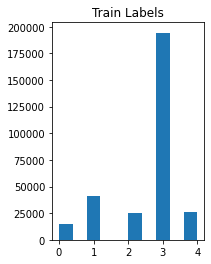

In [ ]:
# Plot training vs validation distribution
plt.subplot (1, 2 , 1)
plt.hist (labels[0:train_size])
plt.title ("Train Labels")

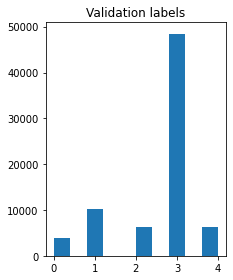

In [ ]:
plt.subplot (1, 2, 1)
plt.hist (labels[train_size:])
plt.title ("Validation labels")
plt.tight_layout()

To create a Dataset using generator we first write a generator function which reads each of the articles from file_paths and the labels from the label array, and yields one training example at each step. We pass this generator function to the tf.data.Dataset.from_generator method and specify the output types. Each training example is a tuple containing an article of tf.string data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using the **skip** and **take** method.

In [ ]:
def load_file (path, label):
  return tf.io.read_file (path), label

In [ ]:
# Create train and test datasets (in batches)

def make_datasets (train_size):
  batch_size = 256

  train_files = file_paths [:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices ((train_files, train_labels))
  train_ds = train_ds.map (load_file).shuffle (5000)
  train_ds = train_ds.batch (batch_size).prefetch (tf.data.experimental.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels [train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices ((test_files, test_labels))
  test_ds = test_ds.map (load_file)
  test_ds = test_ds.batch (batch_size).prefetch (tf.data.experimental.AUTOTUNE)

  return train_ds, test_ds

In [ ]:
train_data, validation_data = make_datasets (train_size)

# Model Training and Evaluation

In [ ]:
# Model 

def create_model ():
  model = tf.keras.Sequential([
    tf.keras.layers.Input (shape = [], dtype = tf.string),
    embedding_layer,
    tf.keras.layers.Dense (64, activation='relu'),
    tf.keras.layers.Dense (16, activation='relu'),
    tf.keras.layers.Dense (5)
  ])

  model.compile (loss = tf.losses.SparseCategoricalCrossentropy (from_logits=True),
                 optimizer = tf.keras.optimizers.Adam (lr = 0.001), metrics = ['accuracy'])
  
  return model

In [ ]:
# Instantiate the model
model = create_model()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 300)               30000300  
_________________________________________________________________
dense_6 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 30,020,689
Trainable params: 20,389
Non-trainable params: 30,000,300
_________________________________________________________________


In [ ]:
# Create EarlyStopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping (monitor = 'val_loss', min_delta = 0, patience = 3)

In [ ]:
# Training the model
history = model.fit (train_data, 
                     validation_data= validation_data,
                     epochs = 5,
                     callbacks = early_stopping_callback)

Epoch 1/5
1176/1176 [==============================] - 375s 310ms/step - loss: 0.3539 - accuracy: 0.8783 - val_loss: 0.1540 - val_accuracy: 0.9477
Epoch 2/5
1176/1176 [==============================] - 164s 139ms/step - loss: 0.1462 - accuracy: 0.9495 - val_loss: 0.1374 - val_accuracy: 0.9503
Epoch 3/5
1176/1176 [==============================] - 122s 103ms/step - loss: 0.1315 - accuracy: 0.9529 - val_loss: 0.1257 - val_accuracy: 0.9544
Epoch 4/5
1176/1176 [==============================] - 133s 112ms/step - loss: 0.1226 - accuracy: 0.9560 - val_loss: 0.1219 - val_accuracy: 0.9553
Epoch 5/5
1176/1176 [==============================] - 133s 112ms/step - loss: 0.1171 - accuracy: 0.9575 - val_loss: 0.1176 - val_accuracy: 0.9571


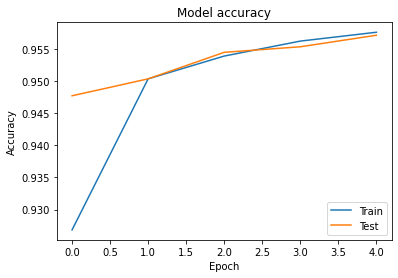

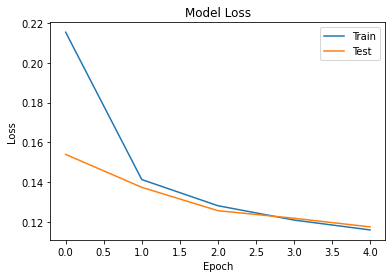

In [ ]:
# Evaluation 
# Plot training and validation accuracy values

plt.plot (history.history ['accuracy'])
plt.plot (history.history ['val_accuracy'])
plt.title ("Model accuracy")
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend (['Train', 'Test'], loc = 'lower right')
plt.show ()

# Plot training and validation loss values
plt.plot (history.history ['loss'])
plt.plot (history.history['val_loss'])
plt.title ('Model Loss')
plt.ylabel ('Loss')
plt.xlabel ('Epoch')
plt.legend (['Train', 'Test'], loc = 'upper right')
plt.show()

# Prediction

In [ ]:
y_pred = model.predict (validation_data)

In [ ]:
y_pred = np.argmax (y_pred, axis = 1)

In [ ]:
samples = file_paths[10:30]
for i, sample in enumerate (samples):
  f = open (sample)
  text = f.read()
  print (text[0:100])
  print ("True Class: ", sample.split ("/")[0])
  print ("Predicted Class: ", dir_names[y_pred[i]])
  f.close()


সৌদি আরবে হজ করতে যাওয়া আরেক বাংলাদেশি মারা গেছেন। এ নিয়ে তিন নারীসহ মোট ১৬ জন বাংলাদেশি মারা গেল
True Class:  state
Predicted Class:  state

বগুড়ার দুপচাঁচিয়া ও কাহালু এবং সিরাজগঞ্জের রায়গঞ্জ উপজেলার বেসরকারি শিক্ষাপ্রতিষ্ঠানের শিক্ষক ও কর্
True Class:  state
Predicted Class:  state

আজ ২৬ জুন। আন্তর্জাতিক নির্যাতনবিরোধী দিবস। জাতিসংঘ ঘোষিত দিবসটি বিশ্বব্যাপী পালিত হয়।
দিবসটি উপলক
True Class:  state
Predicted Class:  state

নওগাঁর নিয়ামতপুর ডিগ্রি কলেজ জাতীয়করণ হওয়ায় গতকাল সোমবার শোভাযাত্রা করেছেন প্রতিষ্ঠানটির শিক্ষক ও 
True Class:  state
Predicted Class:  state

যৌতুক না পেয়ে মৌলভীবাজার সদর উপজেলার শ্যামেরকোণা গ্রামের এক গৃহবধূকে তাঁর স্বামী হাত-পা বেঁধে পিটি
True Class:  state
Predicted Class:  state

চকলেট ও কনফেকশনারি খাদ্য উৎপাদনকারী প্রতিষ্ঠান এলসন ফুডস (বিডি) লিমিটেড আইএসও সনদ ৯০০১ পেয়েছে। গত শ
True Class:  economy
Predicted Class:  sports

মৌলভীবাজারে বন্য প্রাণী ব্যবস্থাপনা ও প্রকৃতি সংরক্ষণ বিভাগের শ্রীমঙ্গল রেঞ্জ কার্যালয়ের একটি তালা
True Class:  state
Predic

In [ ]:
len (file_paths)

376226

In [ ]:
file_paths[29]

'international/20025.txt'